### <a id='sec'> Содержание: </a>
1. [Задача](#sec1)
2. [Описание файлов](#sec2)
3. [Основные поля данных](#sec3)
4. [Первый взгляд на данные и предобработка](#sec4)
5. [Начало работы с моделями](#sec5)
6. [Создание submission для kaggle](#sec6)

### <a id='sec1'> Задача </a>

Участникам предоставлен набор данных объявлений о продаже недвижимости в некотором волшебном городе N. Задача - предсказать цену недвижимости по содержанию объявления.

Метрика данного соревнования mean absolute error (MAE):

Разбиение на Train/Test выполнено по времени объявления.

Разбиение тестового набора на Public/Private выполнено случайным образом в пропорции 30/70% соответственно.

### <a id='sec2'> Описание файлов </a>
* train.csv - тренировочный набор данных
* test.csv - тестовый набор данных
* sampleSubmission.csv - пример формата файла предсказаний (поля: id, price)

### <a id='sec3'> Основные поля данных </a>
* date - дата объявления
* street_id - id улицы
* build_tech - технология построения дома
* floor - этаж дома
* area - площадь недвижимости
* rooms - количество комнат
* balcon - наличие/отсутствие балкона
* metro_dist - расстояние до метро
* g_lift - наличие/отсутствие лифта в доме
* n_photos - количество фото в объявлении
* price - цена недвижимости

Для построения модели помимо вышеперечисленного даны 22 переменные с вполне понятными названиями за исключением: kw1 ... kw13 - это факт наличия некоторых ключевых слов в тексте объявления.

[вернуться в содержание](#sec)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from IPython.display import FileLink

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### <a id='sec4'> Первый взгляд на данные и предобработка </a>

In [ ]:
# код выполнялся из kaggle notebook, поэтому здесь прописан такой путь до файлов
train = pd.read_csv('../input/propertyprices/Train.csv', index_col='id')
test = pd.read_csv('../input/propertyprices/Test.csv')
sample_submission = pd.read_csv('../input/propertyprices/SampleSubmission.csv')

In [ ]:
test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,553,1.0,9,35,1,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,21,0.0,1,41,2,0,10.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,203,1.0,2,52,2,1,15.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,332,NaN,7,36,1,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,581,NaN,6,33,1,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-1,385,NaN,1,59,3,0,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,2489000
1,2011-1,247,NaN,5,53,2,1,15.0,1.0,2,...,0,0,0,0,0,0,0,0,0,1995000
2,2011-1,115,0.0,7,61,3,0,10.0,1.0,1,...,0,0,0,0,0,0,0,0,0,3993000
3,2011-1,491,1.0,5,61,3,1,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,5709000
4,2011-1,623,NaN,3,51,2,1,30.0,NaN,1,...,0,0,0,0,0,0,0,0,0,4374000


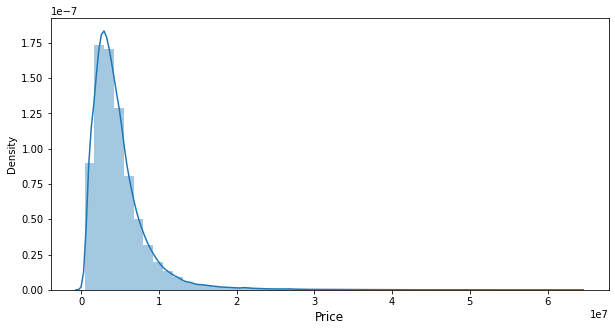

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(train.price, kde=True)
plt.xlabel('Price', fontsize=12)
plt.show()

In [ ]:
train.shape

(100000, 24)

In [ ]:
train.columns

Index(['date', 'street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
       'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
       'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'price'],
      dtype='object')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        100000 non-null  object 
 1   street_id   100000 non-null  int64  
 2   build_tech  70015 non-null   float64
 3   floor       100000 non-null  int64  
 4   area        100000 non-null  int64  
 5   rooms       100000 non-null  int64  
 6   balcon      100000 non-null  int64  
 7   metro_dist  94906 non-null   float64
 8   g_lift      69942 non-null   float64
 9   n_photos    100000 non-null  int64  
 10  kw1         100000 non-null  int64  
 11  kw2         100000 non-null  int64  
 12  kw3         100000 non-null  int64  
 13  kw4         100000 non-null  int64  
 14  kw5         100000 non-null  int64  
 15  kw6         100000 non-null  int64  
 16  kw7         100000 non-null  int64  
 17  kw8         100000 non-null  int64  
 18  kw9         100000 non-null  int64  
 19  kw1

Приводим дату к нужному формату и удаляем ее из датасета.

In [ ]:
train['date'] = pd.to_datetime(train.date, format='%Y-%m-%d')
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['day'] = train.date.dt.day
train.drop(['date'], axis=1, inplace=True)

In [ ]:
train.describe()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month,day
count,100000.000000,70015.00000,100000.000000,100000.000000,100000.00000,100000.000000,94906.000000,69942.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.0
mean,335.037310,0.53300,5.379220,52.281400,2.10986,0.400360,21.655954,0.496297,2.466570,0.056420,...,0.007330,0.007830,0.00204,0.00027,0.001780,0.000230,4.805573e+06,2011.331770,6.488150,1.0
std,194.350178,0.58589,4.057459,17.723931,0.82872,0.557131,8.368395,0.499990,1.943183,0.230732,...,0.085301,0.088141,0.04512,0.01643,0.042153,0.015164,3.760349e+06,0.470851,3.857044,0.0
min,0.000000,0.00000,1.000000,29.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,4.350000e+05,2011.000000,1.000000,1.0
25%,167.000000,0.00000,2.000000,40.000000,1.00000,0.000000,15.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,2.522000e+06,2011.000000,3.000000,1.0
50%,335.000000,0.00000,4.000000,52.000000,2.00000,0.000000,25.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,3.910000e+06,2011.000000,6.000000,1.0
75%,504.000000,1.00000,8.000000,60.000000,3.00000,1.000000,30.000000,1.000000,4.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,5.914000e+06,2012.000000,10.000000,1.0
max,671.000000,2.00000,25.000000,217.000000,6.00000,2.000000,30.000000,1.000000,11.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,6.346300e+07,2012.000000,12.000000,1.0


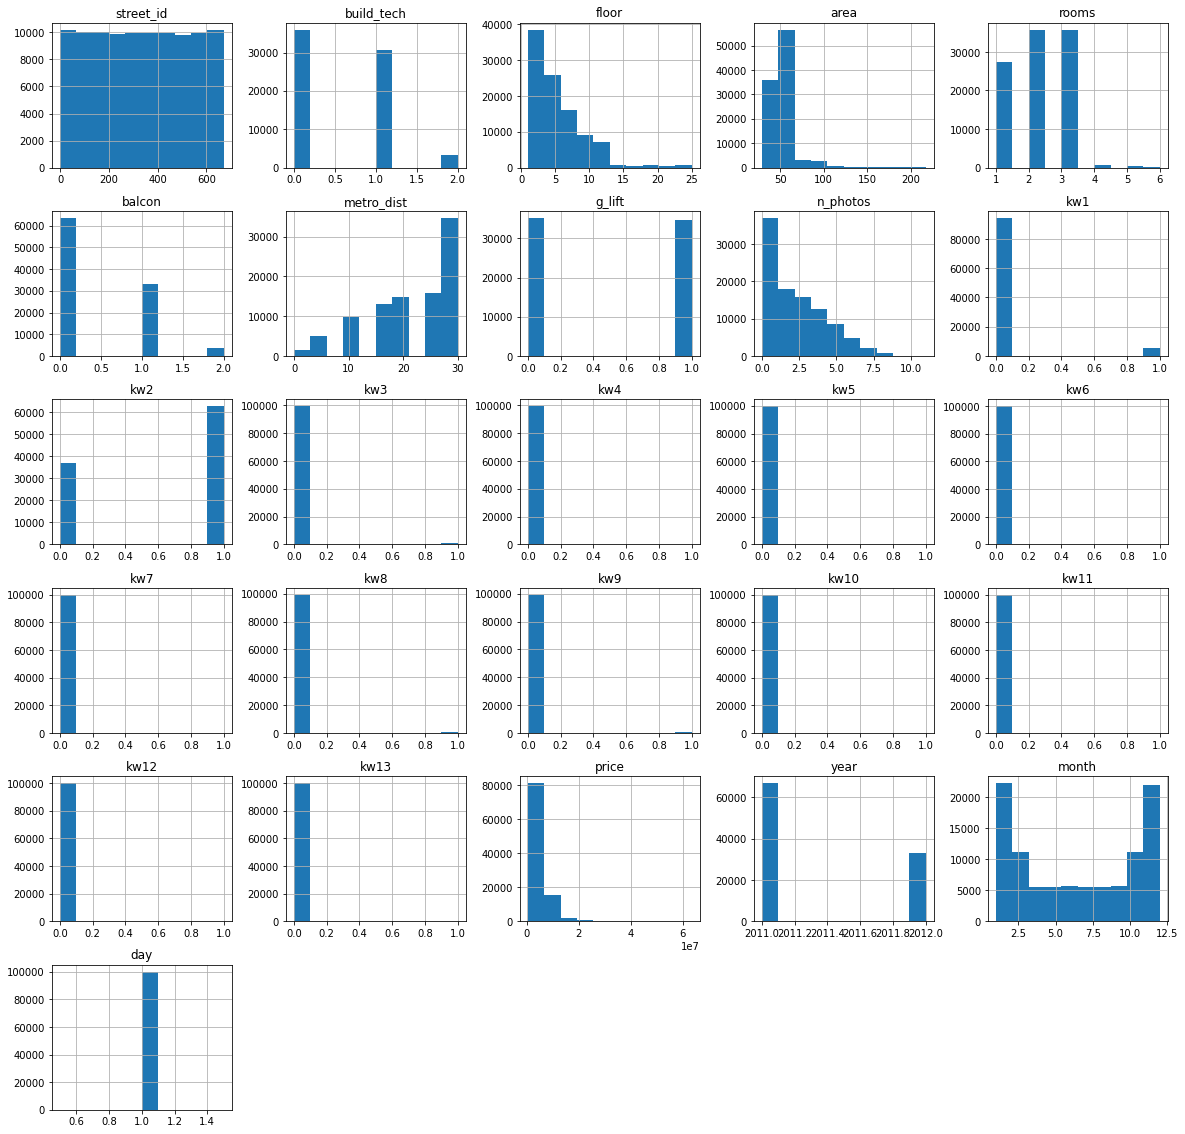

In [ ]:
train.hist(figsize=(20, 20));

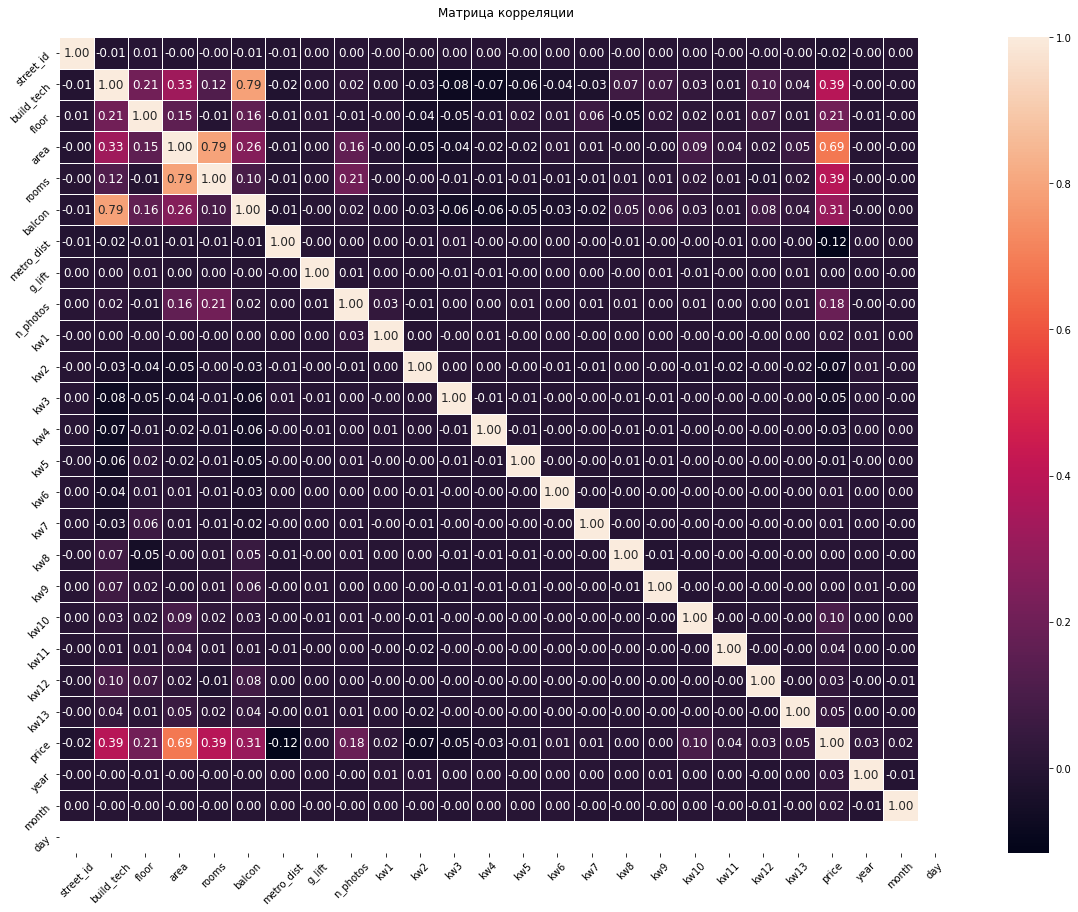

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(train.corr(), 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f",
            annot_kws={'fontsize': 12})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Матрица корреляции\n');

По матрице корреляции определили, что сильно коррелированных признаков (где коэффициент корреляции $\ge$ 0.9 или $\le$ -0.9) не наблюдается в данном наборе данных.

In [ ]:
train.isna().sum()

street_id         0
build_tech    29985
floor             0
area              0
rooms             0
balcon            0
metro_dist     5094
g_lift        30058
n_photos          0
kw1               0
kw2               0
kw3               0
kw4               0
kw5               0
kw6               0
kw7               0
kw8               0
kw9               0
kw10              0
kw11              0
kw12              0
kw13              0
price             0
year              0
month             0
day               0
dtype: int64

Посмотрим, какой процент пропусков содержится в данных.

In [ ]:
print(f'build_tech nans: {train.build_tech.isna().mean() * 100}%')
print(f'metro_dist nans: {train.metro_dist.isna().mean() * 100}%')
print(f'g_lift nans: {train.g_lift.isna().mean() * 100}%')

build_tech nans: 29.985%
metro_dist nans: 5.094%
g_lift nans: 30.058%


In [ ]:
train[['build_tech', 'metro_dist', 'g_lift']].describe()

,build_tech,metro_dist,g_lift
count,70015.00000,94906.000000,69942.000000
mean,0.53300,21.655954,0.496297
std,0.58589,8.368395,0.499990
min,0.00000,0.000000,0.000000
25%,0.00000,15.000000,0.000000
50%,0.00000,25.000000,0.000000
75%,1.00000,30.000000,1.000000
max,2.00000,30.000000,1.000000


In [ ]:
train.build_tech.value_counts()

0.0    36000
1.0    30712
2.0     3303
Name: build_tech, dtype: int64

In [ ]:
train.metro_dist.value_counts()

30.0    34670
25.0    15917
20.0    14836
15.0    13179
10.0     9804
5.0      4962
0.0      1538
Name: metro_dist, dtype: int64

In [ ]:
train.g_lift.value_counts()

0.0    35230
1.0    34712
Name: g_lift, dtype: int64

Заменим пропуски в категориальных признаках на моду (в данном случае это 0.0), а в количественном - на медиану.

In [ ]:
train['build_tech'].fillna(0.0, inplace=True)
train['metro_dist'].fillna(train['metro_dist'].median(), inplace=True)
train['g_lift'].fillna(0.0, inplace=True)

In [ ]:
train['build_tech'] = train['build_tech'].astype('int64')
train['g_lift'] = train['g_lift'].astype('int64')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   street_id   100000 non-null  int64  
 1   build_tech  100000 non-null  int64  
 2   floor       100000 non-null  int64  
 3   area        100000 non-null  int64  
 4   rooms       100000 non-null  int64  
 5   balcon      100000 non-null  int64  
 6   metro_dist  100000 non-null  float64
 7   g_lift      100000 non-null  int64  
 8   n_photos    100000 non-null  int64  
 9   kw1         100000 non-null  int64  
 10  kw2         100000 non-null  int64  
 11  kw3         100000 non-null  int64  
 12  kw4         100000 non-null  int64  
 13  kw5         100000 non-null  int64  
 14  kw6         100000 non-null  int64  
 15  kw7         100000 non-null  int64  
 16  kw8         100000 non-null  int64  
 17  kw9         100000 non-null  int64  
 18  kw10        100000 non-null  int64  
 19  kw1

Аналогичным образом предобрабатываем тестовые данные.

In [ ]:
test['date'] = pd.to_datetime(test.date, format='%Y-%m-%d')
test['year'] = test.date.dt.year
test['month'] = test.date.dt.month
test['day'] = test.date.dt.day
test.drop(['date'], axis=1, inplace=True)

In [ ]:
print(f'build_tech nans: {test.build_tech.isna().mean() * 100}%')
print(f'metro_dist nans: {test.metro_dist.isna().mean() * 100}%')
print(f'g_lift nans: {test.g_lift.isna().mean() * 100}%')

build_tech nans: 30.147000000000002%
metro_dist nans: 4.994%
g_lift nans: 30.122%


In [ ]:
test[['build_tech', 'metro_dist', 'g_lift']].describe()

,build_tech,metro_dist,g_lift
count,69853.000000,95006.000000,69878.000000
mean,0.536283,21.665842,0.497224
std,0.584782,8.387069,0.499996
min,0.000000,0.000000,0.000000
25%,0.000000,15.000000,0.000000
50%,0.000000,25.000000,0.000000
75%,1.000000,30.000000,1.000000
max,2.000000,30.000000,1.000000


In [ ]:
test.build_tech.value_counts()

0.0    35650
1.0    30945
2.0     3258
Name: build_tech, dtype: int64

In [ ]:
test.metro_dist.value_counts()

30.0    34927
25.0    15893
20.0    14592
15.0    13186
10.0     9808
5.0      5108
0.0      1492
Name: metro_dist, dtype: int64

In [ ]:
test.g_lift.value_counts()

0.0    35133
1.0    34745
Name: g_lift, dtype: int64

In [ ]:
test['build_tech'].fillna(0.0, inplace=True)
test['metro_dist'].fillna(test['metro_dist'].median(), inplace=True)
test['g_lift'].fillna(0.0, inplace=True)

In [ ]:
test['build_tech'] = test['build_tech'].astype('int64')
test['g_lift'] = test['g_lift'].astype('int64')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   street_id   100000 non-null  int64  
 2   build_tech  100000 non-null  int64  
 3   floor       100000 non-null  int64  
 4   area        100000 non-null  int64  
 5   rooms       100000 non-null  int64  
 6   balcon      100000 non-null  int64  
 7   metro_dist  100000 non-null  float64
 8   g_lift      100000 non-null  int64  
 9   n_photos    100000 non-null  int64  
 10  kw1         100000 non-null  int64  
 11  kw2         100000 non-null  int64  
 12  kw3         100000 non-null  int64  
 13  kw4         100000 non-null  int64  
 14  kw5         100000 non-null  int64  
 15  kw6         100000 non-null  int64  
 16  kw7         100000 non-null  int64  
 17  kw8         100000 non-null  int64  
 18  kw9         100000 non-null  int64  
 19  kw1

[вернуться в содержание](#sec)

### <a id='sec5'> Начало работы с моделями </a>

In [ ]:
y = train.price

In [ ]:
X = train.drop(['price'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(70000, 25)

In [ ]:
X_test.shape

(30000, 25)

Лучший результат показала модель, состоящая из **XGBRegressor** и **GradientBoostingRegressor** с подобранными с помощью **GridSearch** (cv=5) гиперпараметрами, с применением голосования **VotingRegressor**.

In [ ]:
xgbr_ = XGBRegressor(max_depth=5, 
                     n_estimators=3000, 
                     learning_rate=0.1,
                     n_jobs=10)
gbr_ = GradientBoostingRegressor(loss='huber',
                                 learning_rate=0.25,
                                 n_estimators=3000,
                                 min_samples_leaf=5,
                                 max_depth=5,
                                 random_state=42)

voting = VotingRegressor(estimators=[
    ('xgbr', xgbr_), ('gbr', gbr_)])

voting.fit(X_train, y_train)

VotingRegressor(estimators=[('xgbr',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=3000, n_jobs=10,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                

In [ ]:
voting.score(X_test, y_test)

0.8651001649956691

In [ ]:
mean_absolute_error(y_test, voting.predict(X_test))

626147.9875704665

[вернуться в содержание](#sec)

### <a id='sec6'> Создание submission для kaggle </a>

In [ ]:
cols = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
       'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
       'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'year',
       'month', 'day']

In [ ]:
test['submission'] = voting.predict(test[cols])

In [ ]:
submission = pd.DataFrame(test[['id', 'submission']])
submission.columns = ['id', 'price']
submission.to_csv('property_prices.csv', index=False)

In [ ]:
FileLink(r'property_prices.csv')

/kaggle/working/property_prices.csv

[вернуться в содержание](#sec)